In [17]:
import torch, torchvision
print(torch.__version__)
print(torchvision.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


2.7.0+cu118
0.22.0+cu118
Using device: cuda


In [18]:
#Load Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import torchvision

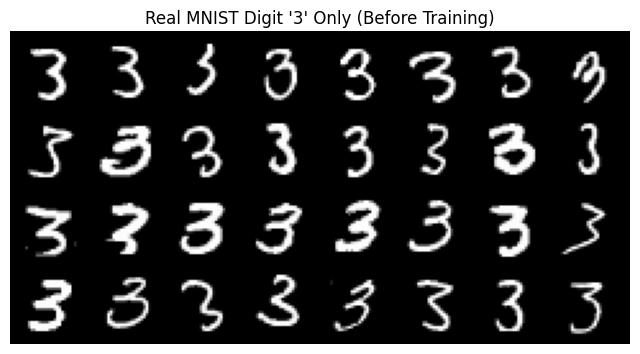

In [19]:
# Load MNIST
transform = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize((0.5,), (0.5,)),
])

dataset = datasets.MNIST(root='./data', train=True, transform=transform,
download=True)
loader = DataLoader(dataset, batch_size=64, shuffle=True)
target_digit = 3 # you can change this based on your last digit student number

# Reload MNIST and filter to only target_digit
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
filtered_indices = [i for i, (_, label) in enumerate(dataset) if label == target_digit]
filtered_dataset = Subset(dataset, filtered_indices[:5000]) # limit to 5000 samples
loader = DataLoader(filtered_dataset, batch_size=64, shuffle=True)

# Visualize filtered samples
examples = next(iter(loader))[0][:32]
examples = examples * 0.5 + 0.5
grid = torchvision.utils.make_grid(examples, nrow=8, padding=2, normalize=True)
plt.figure(figsize=(8, 8))
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.title(f"Real MNIST Digit '{target_digit}' Only (Before Training)")
plt.axis("off")
plt.show()

In [20]:
# ====== Generator and Discriminator Definitions ======
# Define the Generator
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_dim=784):
        super().__init__()
        self.gen = nn.Sequential(
            # Define your generator architecture here
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, img_dim),
            nn.Tanh() # To output values between -1 and 1, matching normalized image data
        )
    def forward(self, x):
        return self.gen(x)

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self, img_dim=784):
        super().__init__()
        self.disc = nn.Sequential(
            # Define your discriminator architecture here
            nn.Linear(img_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid() # To output a probability (0 to 1)
        )
    def forward(self, x):
        return self.disc(x)

In [21]:
# ========== Training Setup ==========
# Initialize networks and optimizers, you can adjust the parameters
z_dim = 100
img_dim = 28 * 28
lr = 0.0002
gen = Generator(z_dim, img_dim).to(device)
disc = Discriminator(img_dim).to(device)
criterion = nn.BCELoss()
opt_gen = optim.Adam(gen.parameters(), lr)
opt_disc = optim.Adam(disc.parameters(), lr)
num_epochs=50


In [22]:
# Write training loop with GAN adversarial loss here
# TODO: implement training loop with real/fake labels, forward passes, and optim steps
# Example training loop (pseudo-code):
# 1. Loop over epochs and batches:
for epoch in range(num_epochs):
    loss_disc_epoch = 0.0
    loss_gen_epoch = 0.0
    num_batches = 0

    for batch_idx, (real_imgs, _) in enumerate(loader):
        # 2. Flatten and move real images to the device:
        real_imgs = real_imgs.view(-1, img_dim).to(device) # Flatten images
        batch_size = real_imgs.size(0)

        # Labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # 4. Train Discriminator
        # Train on Real Images
        opt_disc.zero_grad()
        outputs_real = disc(real_imgs)
        loss_disc_real = criterion(outputs_real, real_labels)

        # Train on Fake Images
        # Generate fake images from noise:
        noise = torch.randn(batch_size, z_dim).to(device)
        fake_imgs = gen(noise)
        outputs_fake = disc(fake_imgs.detach()) # Detach to avoid training generator here
        loss_disc_fake = criterion(outputs_fake, fake_labels)

        loss_disc_total = (loss_disc_real + loss_disc_fake) / 2
        loss_disc_total.backward()
        opt_disc.step()

        # 5. Train Generator
        # We want the discriminator to classify fake images as real (label 1)
        opt_gen.zero_grad()
        outputs_fake_for_gen = disc(fake_imgs) # Use the same fake_imgs, but don't detach
        loss_gen = criterion(outputs_fake_for_gen, real_labels) # Fool the discriminator
        loss_gen.backward()
        opt_gen.step()
        
        loss_disc_epoch += loss_disc_total.item()
        loss_gen_epoch += loss_gen.item()
        num_batches +=1

    avg_loss_disc = loss_disc_epoch / num_batches if num_batches > 0 else 0
    avg_loss_gen = loss_gen_epoch / num_batches if num_batches > 0 else 0
    
    # 6. Print epoch loss values:
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss D: {avg_loss_disc:.4f}, Loss G: {loss_gen:.4f}")


Epoch [1/50] Loss D: 0.4877, Loss G: 0.8236
Epoch [2/50] Loss D: 0.4372, Loss G: 1.3099
Epoch [3/50] Loss D: 0.2079, Loss G: 1.9677
Epoch [4/50] Loss D: 0.1036, Loss G: 2.4521
Epoch [5/50] Loss D: 0.1397, Loss G: 1.8493
Epoch [6/50] Loss D: 0.3008, Loss G: 1.0837
Epoch [7/50] Loss D: 0.5588, Loss G: 1.0120
Epoch [8/50] Loss D: 0.5476, Loss G: 1.4040
Epoch [9/50] Loss D: 0.4114, Loss G: 0.9374
Epoch [10/50] Loss D: 0.3192, Loss G: 1.0269
Epoch [11/50] Loss D: 0.2800, Loss G: 1.0857
Epoch [12/50] Loss D: 0.4270, Loss G: 1.4755
Epoch [13/50] Loss D: 0.3949, Loss G: 1.2829
Epoch [14/50] Loss D: 0.4178, Loss G: 1.1443
Epoch [15/50] Loss D: 0.3027, Loss G: 1.6450
Epoch [16/50] Loss D: 0.3333, Loss G: 1.4851
Epoch [17/50] Loss D: 0.2238, Loss G: 1.4672
Epoch [18/50] Loss D: 0.4106, Loss G: 1.4992
Epoch [19/50] Loss D: 0.2752, Loss G: 1.0325
Epoch [20/50] Loss D: 0.4590, Loss G: 1.4280
Epoch [21/50] Loss D: 0.4460, Loss G: 1.0944
Epoch [22/50] Loss D: 0.6062, Loss G: 1.3739
Epoch [23/50] Loss 

Training finished. Visualizing final generated samples.


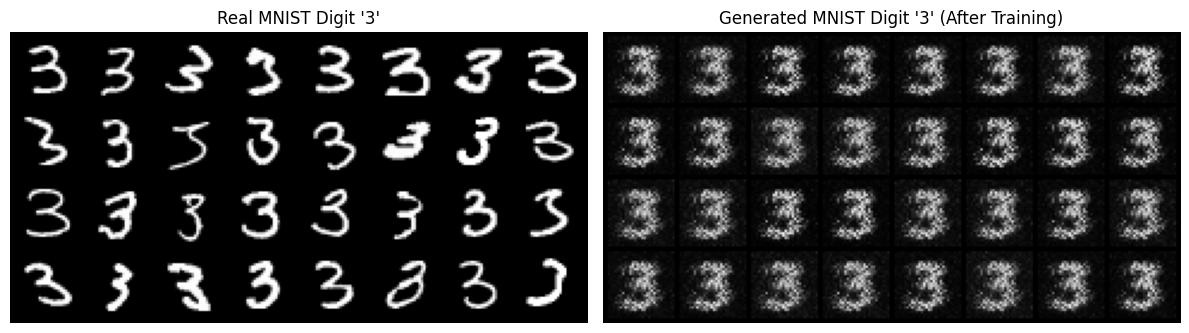

In [23]:
print("Training finished. Visualizing final generated samples.")
with torch.no_grad():
    gen.eval()
    final_noise = torch.randn(64, z_dim).to(device) # Generate 64 samples
    final_generated_images = gen(final_noise).view(-1, 1, 28, 28)
    final_generated_images = final_generated_images * 0.5 + 0.5 # Denormalize

    # For comparison, show some real images again
    if len(loader) > 0:
        real_examples_for_comparison = next(iter(loader))[0][:32] # Take 32 real images
        real_examples_for_comparison = real_examples_for_comparison * 0.5 + 0.5 # Denormalize
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 6)) # Create a figure with two subplots
        
        # Plot real images
        grid_real = torchvision.utils.make_grid(real_examples_for_comparison.cpu(), nrow=8, padding=2, normalize=False)
        axes[0].imshow(np.transpose(grid_real.numpy(), (1, 2, 0)))
        axes[0].set_title(f"Real MNIST Digit '{target_digit}'")
        axes[0].axis("off")

        # Plot generated images
        grid_fake = torchvision.utils.make_grid(final_generated_images.cpu()[:32], nrow=8, padding=2, normalize=False) # Take 32 fake images
        axes[1].imshow(np.transpose(grid_fake.numpy(), (1, 2, 0)))
        axes[1].set_title(f"Generated MNIST Digit '{target_digit}' (After Training)")
        axes[1].axis("off")
        
        plt.tight_layout()
        plt.show()
    else: # Only show generated if no real images were loaded
        grid_final_fake = torchvision.utils.make_grid(final_generated_images.cpu(), nrow=8, padding=2, normalize=False)
        plt.figure(figsize=(8, 8))
        plt.imshow(np.transpose(grid_final_fake.numpy(), (1, 2, 0)))
        plt.title(f"Generated MNIST Digit '{target_digit}' (After Training - No Real Images for Comparison)")
        plt.axis("off")
        plt.show()
    gen.train()
